In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
from statistics import mean

In [2]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 10
batch_size = 32
lr = 0.01
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ])
train_val_dataset = datasets.CIFAR10('.', download=True, train=True, transform=transform)
test_dataset = datasets.CIFAR10('.', download=True, train=False, transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def plot_graph(training_losses,val_losses,epochs):
    plt.figure()
    plt.plot(range(epochs),training_losses,label="Training loss")
    plt.plot(range(epochs),val_losses,label="Validation loss")
    plt.legend()
    plt.title('Loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.encoder = nn.Sequential(
            # 3 input channels(RGB), 12 output channels, 3x3 square convolution
            nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 24, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, stride=2, padding=1), # Output size : [batch_size, 48, 16, 16]
            
        )
        self.fc = nn.Sequential(
            nn.Linear(12288,1200),
            nn.ReLU(),
            nn.Linear(1200,500),
            nn.ReLU(),
            nn.Linear(500,10),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.encoder(x)
        #x = x.view(-1, 320)
        x = x.view(x.size(0),-1)
        #x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return x

In [6]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,labels)
            epoch_loss += loss.item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss



C:\Users\Martin Dimitrov\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 1.849683449459076
Average loss: 1.5566, Accuracy: 4433/10000 (44%)
Average training loss: 1.421746862077713
Average loss: 1.2980, Accuracy: 5405/10000 (54%)
Average training loss: 1.1745632361888885
Average loss: 1.1551, Accuracy: 5933/10000 (59%)
Average training loss: 0.9568488050937652
Average loss: 1.0721, Accuracy: 6252/10000 (63%)
Average training loss: 0.7402486313581467
Average loss: 1.1310, Accuracy: 6230/10000 (62%)
Average training loss: 0.5036747692108154
Average loss: 1.2701, Accuracy: 6144/10000 (61%)
Average training loss: 0.35156476864814756
Average loss: 1.5379, Accuracy: 6150/10000 (62%)
Average training loss: 0.2500807348653674
Average loss: 1.6284, Accuracy: 6207/10000 (62%)
Average training loss: 0.1997713259115815
Average loss: 1.8801, Accuracy: 6142/10000 (61%)
Average training loss: 0.16453454619981348
Average loss: 2.0673, Accuracy: 6095/10000 (61%)
Final performance
Average loss: 2.0682, Accuracy: 6103/10000 (61%)


2.068198137199536

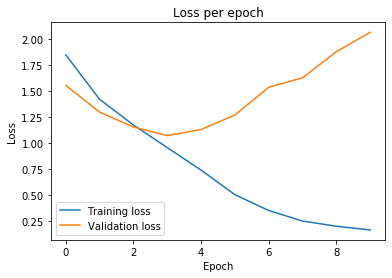

In [7]:
model = Classifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot_graph(training_losses,val_losses,epochs)
test(model,device,testloader,criterion)

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # batch_size : 64
        # Input size to the Autoencoder : [batch_size, 3, 32, 32]
        # Output size from the Autoencoder : [batch_size, 3, 32, 32]
        self.encoder = nn.Sequential(
            # 3 input channels(RGB), 12 output channels, 3x3 square convolution
            nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 24, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, stride=2, padding=1), # Output size : [batch_size, 48, 16, 16]
            #nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            # For Upscaling :
            # 2x2 kernels can only learn nearest pixel upscaling.
            # 3x3 kernels can do bilinear but will require asymmetric padding.
            # But 4x4 can do bilinear again without asymmetrical padding.
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # Output size: [batch_size, 24, 32, 32]
            nn.ReLU(),  #TODO : try with LeakyReLU while decoding
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=1), # Output size: [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 3, stride=1, padding=1), # Output size: [batch_size, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,images)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,images)
            epoch_loss += loss.item()
    epoch_loss /= len(testloader)
    print('Average validation loss: {:.4f}'.format(epoch_loss))
    return epoch_loss



In [10]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot_graph(training_losses,val_losses,epochs)
test(model,device,testloader,criterion)


Average training loss: 0.0031912503452738747
Average validation loss: 0.0004
Average training loss: 0.0005172801840933972
Average validation loss: 0.0003


KeyboardInterrupt: 

In [ ]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output = model(test_images)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

In [ ]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            # 3 input channels(RGB), 12 output channels, 3x3 square convolution
            nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 24, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, stride=2, padding=1), # Output size : [batch_size, 48, 16, 16]
            #nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            # For Upscaling :
            # 2x2 kernels can only learn nearest pixel upscaling.
            # 3x3 kernels can do bilinear but will require asymmetric padding.
            # But 4x4 can do bilinear again without asymmetrical padding.
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # Output size: [batch_size, 24, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=1), # Output size: [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 3, stride=1, padding=1), # Output size: [batch_size, 3, 32, 32]
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(12288,1200),
            nn.ReLU(),
            nn.Linear(1200,500),
            nn.ReLU(),
            nn.Linear(500,10),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(encoded.size(0),-1)
        predicted = self.classifier(encoded)
        return decoded, predicted

In [ ]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted,labels)
        loss = loss1+loss2
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss1 = criterion1(decoded,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss

In [ ]:
model = Mixed().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader)
    val_loss = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot_graph(training_losses,val_losses,epochs)
test(model,device,testloader)

In [ ]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
print(test_images.shape)
print(test_output.shape)
for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(image_output)
    plt.show()